In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from PIL import Image

size = [32, 32]

ai_arr = []
for i in range(1, 51):
    img = Image.open('Processed/Ai/' + str(i) + '.jpg')
    temp_ai_arr = tf.image.resize(img, size).numpy()
    ai_arr.append(temp_ai_arr)
    
real_arr = []
for i in range(1, 70):
    img = Image.open('Processed/Real/' + str(i) + '.jpg')
    img = np.array(img)[(2240-2048)//2: (2240+2048)//2, (3984-2048)//2: (3984+2048)//2]
    temp_real_arr = tf.image.resize(img, size).numpy()
    real_arr.append(temp_real_arr)

In [3]:
#Make the range of data from [0, 255] -> [-1, 1]
processed_real_arr = np.array(real_arr) / 255 * 2 - 1
processed_ai_arr = np.array(ai_arr) / 255 * 2 - 1

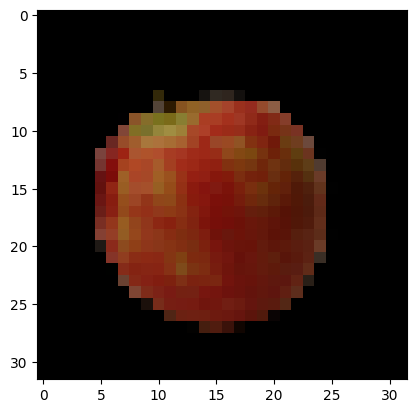

In [4]:
import matplotlib.pyplot as plt
plt.imshow(processed_real_arr[0] / 2 + 0.5)

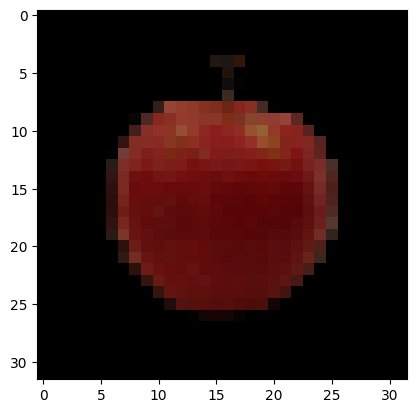

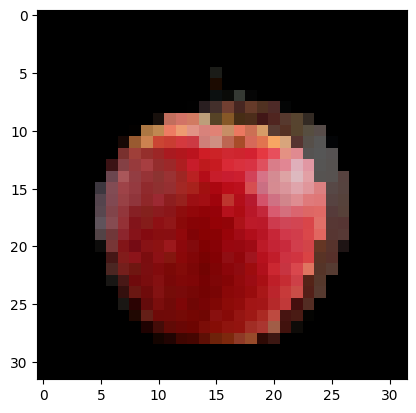

In [183]:
def generate_real_apple(n = 1):
    apples = []
    for _ in range(n):
        s = 1 + np.random.geometric(0.5)
        x = np.random.choice(range(69), min(s, 69), replace=False)
        W = [np.random.rand() for _ in range(s)]
        w = [W[i] / sum(W) for i in range(s)]
        new_arr = np.zeros(processed_real_arr[0].shape)
        for i in range(s):
            new_arr += np.array(processed_real_arr[x[i]]) * w[i]
        apples.append(new_arr)
    return np.array(apples)

def generate_ai_apple(n = 1):
    apples = []
    for _ in range(n):
        s = 1 + np.random.geometric(0.5)
        x = np.random.choice(range(50), min(s, 50), replace=False)
        W = [np.random.rand() for _ in range(s)]
        w = [W[i] / sum(W) for i in range(s)]
        new_arr = np.zeros(processed_ai_arr[0].shape)
        for i in range(s):
            new_arr += np.array(processed_ai_arr[x[i]]) * w[i]
        apples.append(new_arr)
    return np.array(apples)
        
new_arr = generate_real_apple()
plt.imshow(new_arr[0] / 2 + 0.5)
plt.show()
new_arr = generate_ai_apple()
plt.imshow(new_arr[0] / 2 + 0.5)
plt.show()

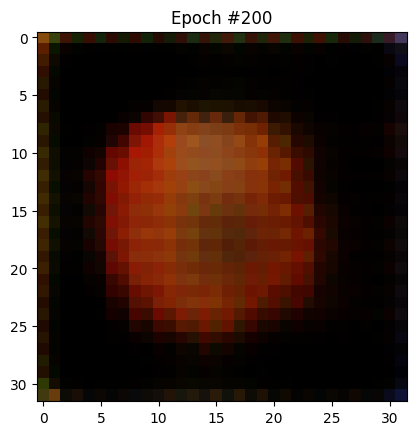

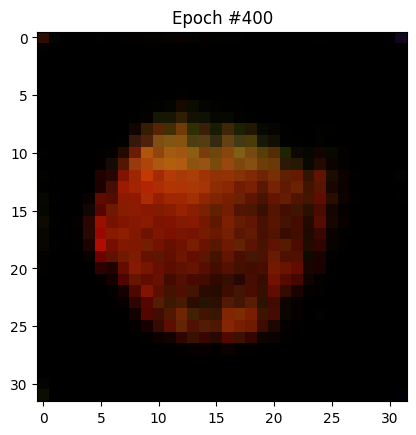

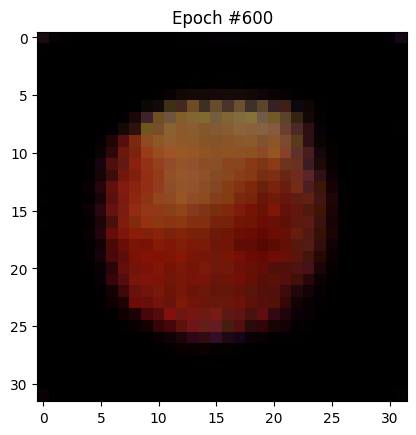

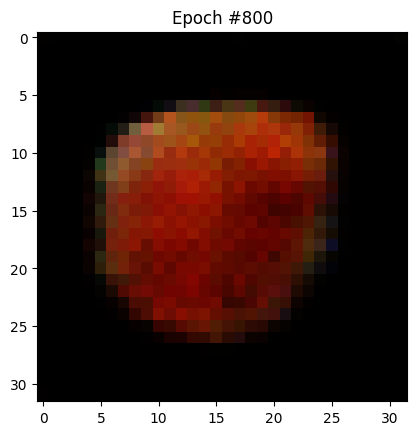

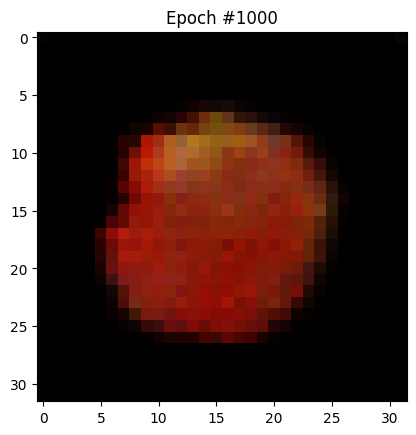

In [194]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

batch_size = 8
epochs = 1000
frequency = 200
input_dimension = 8
output_shape = (*size, 3)

#Generator
generator = Sequential()
generator.add(Dense(4096, input_dim = input_dimension))
generator.add(LeakyReLU(0.2))
generator.add(Reshape([4, 4, 256]))
generator.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(3, (3, 3), activation = 'tanh', padding = 'same'))

#Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (3, 3), padding = 'same', input_shape = output_shape))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(256, (3, 3), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation = 'sigmoid'))

# Compile the models
opt = Adam(learning_rate = 1e-4, beta_1 = 0.5)
discriminator.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

# Define the GAN model
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=opt)

for epoch in range(epochs):
    # Generate fake data
    noise = np.random.normal(size=(batch_size, input_dimension))
    generated_image = np.array(generator.predict(noise, verbose=0))

    if epoch % frequency == frequency - 1:
        plt.imshow(generated_image[0].reshape([*size, 3]) * 0.5 + 0.5)
        plt.title("Epoch #" + str(epoch + 1))
        plt.show()

    # X = np.concatenate([generated_image, x_train.reshape([80, -1])])
    # Y = np.concatenate([np.zeros(batch_size), y_train])

    # random_real_index = np.random.choice(list(range(69)), size=batch_size, replace=False)
    # random_real_data = np.concatenate([processed_real_arr[i] for i in random_real_index]).reshape([batch_size, *size, 3])
    random_real_data = generate_real_apple(batch_size)

    # random_ai_index = np.random.choice(list(range(50)), size=batch_size, replace=False)
    # random_ai_data = np.concatenate([processed_ai_arr[i] for i in random_ai_index]).reshape([batch_size, *size, 3])
    random_ai_data = generate_ai_apple(batch_size)

    # X = np.concatenate([generated_image, random_data])
    # Y = np.concatenate([np.zeros(batch_size), np.ones(batch_size)])

    discriminator.trainable = True
    # loss_d = discriminator.train_on_batch(X, Y)

    # noise_2 = np.random.uniform(-1, 1, [batch_size, *output_shape])

    loss_d_1 = discriminator.train_on_batch(random_real_data, np.ones(batch_size))
    loss_d_2 = discriminator.train_on_batch(random_ai_data, np.zeros(batch_size))
    loss_d_3 = discriminator.train_on_batch(generated_image, np.zeros(batch_size))
    # loss_d_4 = discriminator.train_on_batch(noise_2, np.zeros(batch_size))

    Y_gen = np.ones(batch_size)
    discriminator.trainable = False
    loss_g = gan.train_on_batch(noise, Y_gen)

    # print(epoch, np.linalg.norm(loss_d_1 + loss_d_2 + loss_d_3), loss_g)

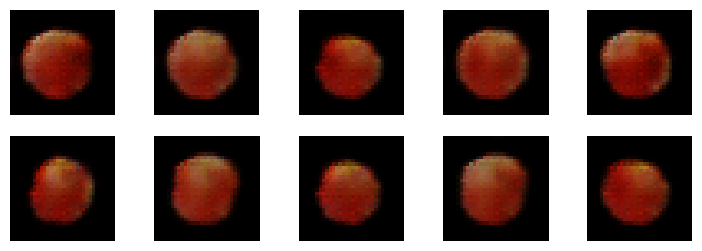

In [195]:
# Generate 10 Apples
noise = np.random.normal(size=(10, input_dimension))
generated_image = np.array(generator.predict(noise, verbose=0))

fig = plt.figure(figsize=(9, 3))

for i in range(10):
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(generated_image[i].reshape([*size, 3]) * 0.5 + 0.5)
    plt.axis('off')